In [1]:
import pandas as pd
import numpy as np
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix

print("=" * 80)
print("PREDICTION WITH PRE-TRAINED OPTIMIZED MODELS")
print("=" * 80)

PREDICTION WITH PRE-TRAINED OPTIMIZED MODELS


1. LOAD DATA

In [3]:
print("\n[1] Loading Data...")

train = pd.read_csv('C:\\Users\\Kanyavan\\Documents\\Year3_semester1\\ML\\CPE342-Hackathon\\task2\\train.csv')
test = pd.read_csv('C:\\Users\\Kanyavan\\Documents\\Year3_semester1\\ML\\CPE342-Hackathon\\task2\\test.csv')


[1] Loading Data...


In [4]:
X_train = train.drop(['id', 'player_id', 'segment'], axis=1)
y_train = train['segment'].astype(int)
X_test = test.drop(['id', 'player_id'], axis=1)
test_ids = test['id']

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Train shape: (101658, 47)
Test shape: (25889, 46)


2. FEATURE ENGINEERING (Same as tuning script)

In [6]:
print("\n[2] Feature Engineering...")


[2] Feature Engineering...


In [16]:
def engineer_features(df):
    df = df.copy()

    # Spending features
    df['spending_per_hour'] = df['total_spending_thb'] / (df['total_playtime_hours'] + 1)
    df['spending_intensity'] = df['avg_monthly_spending'] * df['spending_frequency']
    df['is_spender'] = (df['total_spending_thb'] > 0).astype(int)

    # Engagement features
    df['engagement_score'] = (df['play_frequency'] * df['avg_session_duration'] * df['login_streak']).fillna(0)
    df['activity_consistency'] = df['login_streak'] / (df['days_since_last_login'] + 1)

    # Social features
    df['social_score'] = (df['friend_count'] * df['team_play_percentage'] * df['chat_activity_score']).fillna(0)
    df['is_social_player'] = (df['team_play_percentage'] > 50).astype(int)

    # Competitive features
    df['competitive_score'] = (df['ranked_participation_rate'] * df['tournament_entries'] * df['competitive_rank']).fillna(0)
    df['is_competitive'] = (df['ranked_participation_rate'] > 50).astype(int)

    # Remove random metrics
    df = df.drop(['random_metric_1', 'random_metric_2', 'random_metric_3'], axis=1, errors='ignore')

    return df

X_train_eng = engineer_features(X_train)
X_test_eng = engineer_features(X_test)

print(f"Features after engineering: {X_train_eng.shape[1]}")

Features after engineering: 50


3. PREPROCESSING

In [17]:
print("\n[3] Preprocessing...")


[3] Preprocessing...


In [18]:
numerical_features = X_train_eng.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train_eng.select_dtypes(include=['object']).columns.tolist()

In [19]:
# Label Encoding
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    combined = pd.concat([X_train_eng[col], X_test_eng[col]], axis=0).astype(str)
    le.fit(combined)
    X_train_eng[col] = le.transform(X_train_eng[col].astype(str))
    X_test_eng[col] = le.transform(X_test_eng[col].astype(str))
    label_encoders[col] = le

# Imputation
num_imputer = SimpleImputer(strategy='median')
X_train_eng[numerical_features] = num_imputer.fit_transform(X_train_eng[numerical_features])
X_test_eng[numerical_features] = num_imputer.transform(X_test_eng[numerical_features])

if categorical_features:
    cat_imputer = SimpleImputer(strategy='most_frequent')
    X_train_eng[categorical_features] = cat_imputer.fit_transform(X_train_eng[categorical_features])
    X_test_eng[categorical_features] = cat_imputer.transform(X_test_eng[categorical_features])

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_eng)
X_test_scaled = scaler.transform(X_test_eng)

print("Preprocessing completed!")

Preprocessing completed!


4. LOAD PRE-TRAINED OPTIMIZED MODELS

In [20]:
print("\n[4] Loading Pre-trained Optimized Models...")


[4] Loading Pre-trained Optimized Models...


In [21]:
try:
    with open('model_xgboost_optimized.pkl', 'rb') as f:
        model_xgb = pickle.load(f)
    print("✓ Loaded XGBoost model")
except FileNotFoundError:
    print("✗ XGBoost model not found. Run hyperparameter_tuning_optuna.py first!")
    model_xgb = None

try:
    with open('model_lightgbm_optimized.pkl', 'rb') as f:
        model_lgbm = pickle.load(f)
    print("✓ Loaded LightGBM model")
except FileNotFoundError:
    print("✗ LightGBM model not found. Run hyperparameter_tuning_optuna.py first!")
    model_lgbm = None

try:
    with open('model_catboost_optimized.pkl', 'rb') as f:
        model_cat = pickle.load(f)
    print("✓ Loaded CatBoost model")
except FileNotFoundError:
    print("✗ CatBoost model not found. Run hyperparameter_tuning_optuna.py first!")
    model_cat = None

✓ Loaded XGBoost model
✓ Loaded LightGBM model
✓ Loaded CatBoost model


In [22]:
# Check if at least one model is loaded
loaded_models = {}
if model_xgb is not None:
    loaded_models['XGBoost'] = model_xgb
if model_lgbm is not None:
    loaded_models['LightGBM'] = model_lgbm
if model_cat is not None:
    loaded_models['CatBoost'] = model_cat

if not loaded_models:
    print("\n❌ ERROR: No optimized models found!")
    print("Please run 'hyperparameter_tuning_optuna.py' first to train and save models.")
    exit(1)

print(f"\n✓ Successfully loaded {len(loaded_models)} model(s)")


✓ Successfully loaded 3 model(s)


5. EVALUATE ON TRAINING DATA

In [23]:
print("\n[5] Evaluating Models on Training Data...")

for name, model in loaded_models.items():
    y_train_pred = model.predict(X_train_scaled)
    f1 = f1_score(y_train, y_train_pred, average='macro')
    print(f"{name:20s} | Training Macro F1: {f1:.4f}")


[5] Evaluating Models on Training Data...
XGBoost              | Training Macro F1: 0.9023
LightGBM             | Training Macro F1: 0.8719
CatBoost             | Training Macro F1: 0.8388


6. CREATE ENSEMBLE (if multiple models available)

In [24]:
print("\n[6] Creating Ensemble...")


[6] Creating Ensemble...


In [26]:
if len(loaded_models) >= 2:
    print("Creating Stacking Ensemble with loaded models...")
    
    # Prepare estimators for stacking
    estimators = [(name, model) for name, model in loaded_models.items()]
    
    # Create and train stacking classifier
    stacking_clf = StackingClassifier(
        estimators=estimators,
        final_estimator=LogisticRegression(max_iter=1000, random_state=42),
        cv=5,
        n_jobs=-1
    )
    
    # Note: Stacking needs to be trained on the original data
    # Since our loaded models were trained on SMOTE-balanced data,
    # we'll use soft voting instead for better results
    print("Using Soft Voting Ensemble instead (better for pre-trained models)...")
    
    # Make predictions from each model
    predictions = {}
    for name, model in loaded_models.items():
        pred = model.predict(X_test_scaled)
        predictions[name] = pred.flatten() if hasattr(pred, 'flatten') else pred
    
    # Soft voting: majority vote
    from scipy import stats
    pred_array = np.vstack(list(predictions.values()))
    y_pred_ensemble = stats.mode(pred_array, axis=0, keepdims=False)[0]
    
    # Evaluate ensemble on training data
    train_predictions = {}
    for name, model in loaded_models.items():
        pred = model.predict(X_train_scaled)
        train_predictions[name] = pred.flatten() if hasattr(pred, 'flatten') else pred
    train_pred_array = np.vstack(list(train_predictions.values()))
    y_train_pred_ensemble = stats.mode(train_pred_array, axis=0, keepdims=False)[0]
    
    ensemble_f1 = f1_score(y_train, y_train_pred_ensemble, average='macro')
    print(f"Ensemble (Voting)     | Training Macro F1: {ensemble_f1:.4f}")
    
    use_ensemble = True
    
else:
    print("Only one model loaded, using single model predictions...")
    use_ensemble = False

Creating Stacking Ensemble with loaded models...
Using Soft Voting Ensemble instead (better for pre-trained models)...
Ensemble (Voting)     | Training Macro F1: 0.8770


7. MAKE FINAL PREDICTIONS

In [27]:
print("\n[7] Making Final Predictions...")


[7] Making Final Predictions...


In [28]:
if use_ensemble:
    print("Using Ensemble predictions...")
    y_pred = y_pred_ensemble
    best_model_name = "Ensemble (Voting)"
else:
    # Use the single loaded model
    model_name = list(loaded_models.keys())[0]
    print(f"Using {model_name} predictions...")
    y_pred = loaded_models[model_name].predict(X_test_scaled)
    best_model_name = model_name

Using Ensemble predictions...


8. CREATE SUBMISSION

In [29]:
print("\n[8] Creating Submission File...")


[8] Creating Submission File...


In [30]:
submission = pd.DataFrame({
    'id': test_ids,
    'segment': y_pred.astype(int)
})

submission.to_csv('task2_submission_optimized.csv', index=False)

print(f"\n✓ Submission saved to 'task2_submission_optimized.csv'")
print(f"Predictions shape: {submission.shape}")
print(f"\nPredicted segment distribution:")
print(submission['segment'].value_counts().sort_index())


✓ Submission saved to 'task2_submission_optimized.csv'
Predictions shape: (25889, 2)

Predicted segment distribution:
segment
0    10888
1     6308
2     4976
3     3717
Name: count, dtype: int64


9. SUMMARY

In [31]:
print("\n" + "=" * 80)
print("PREDICTION COMPLETED SUCCESSFULLY!")
print("=" * 80)
print(f"Model used: {best_model_name}")
print(f"Submission file: task2_submission_optimized.csv")
print("=" * 80)

# Display detailed classification report if ensemble
if use_ensemble:
    print("\nDetailed Ensemble Performance on Training Data:")
    print(classification_report(y_train, y_train_pred_ensemble, 
                              target_names=['Casual', 'Grinder', 'Social', 'Whale']))
    
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_train, y_train_pred_ensemble)
    print(cm)


PREDICTION COMPLETED SUCCESSFULLY!
Model used: Ensemble (Voting)
Submission file: task2_submission_optimized.csv

Detailed Ensemble Performance on Training Data:
              precision    recall  f1-score   support

      Casual       0.88      0.92      0.90     40064
     Grinder       0.87      0.86      0.87     25397
      Social       0.88      0.84      0.86     20549
       Whale       0.90      0.86      0.88     15648

    accuracy                           0.88    101658
   macro avg       0.88      0.87      0.88    101658
weighted avg       0.88      0.88      0.88    101658


Confusion Matrix:
[[36939  1819  1083   223]
 [ 2581 21815   488   513]
 [ 1971   610 17269   699]
 [  584   754   799 13511]]


In [1]:
import pandas as pd
import numpy as np
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
print("\n[1] Loading Data...")

train = pd.read_csv('C:\\Users\\Kanyavan\\Documents\\Year3_semester1\\ML\\CPE342-Hackathon\\task2\\train.csv')
test = pd.read_csv('C:\\Users\\Kanyavan\\Documents\\Year3_semester1\\ML\\CPE342-Hackathon\\task2\\test.csv')

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")



[1] Loading Data...
Train shape: (101658, 47)
Test shape: (25889, 46)


In [3]:
X_train = train.drop(['id', 'player_id', 'segment'], axis=1)
y_train = train['segment'].astype(int)
X_test = test.drop(['id', 'player_id'], axis=1)
test_ids = test['id']


In [4]:
print("\n[2] Feature Engineering...")
print("Applying same advanced features as training...")

def create_advanced_features(df):
    """Create advanced features - MUST MATCH TRAINING"""
    df = df.copy()

    # Spending Features
    df['log_total_spending'] = np.log1p(df['total_spending_thb'])
    df['log_monthly_spending'] = np.log1p(df['avg_monthly_spending'])
    df['spending_per_hour'] = df['total_spending_thb'] / (df['total_playtime_hours'] + 1)
    df['spending_per_day'] = df['total_spending_thb'] / (df['account_age_days'] + 1)
    df['spending_per_session'] = df['total_spending_thb'] / (df['total_playtime_hours'] / (df['avg_session_duration'] / 60) + 1)
    df['spending_intensity'] = df['avg_monthly_spending'] * df['spending_frequency']
    df['spending_per_friend'] = df['total_spending_thb'] / (df['friend_count'] + 1)
    df['is_spender'] = (df['total_spending_thb'] > 0).astype(int)
    df['is_whale_candidate'] = ((df['total_spending_thb'] > df['total_spending_thb'].quantile(0.9)) | (df['vip_tier'] >= 5)).astype(int)
    df['vip_spending_ratio'] = df['vip_tier'] * df['total_spending_thb']
    df['rare_item_value'] = df['rare_items_count'] * np.log1p(df['total_spending_thb'])

    # Engagement Features
    df['playtime_per_day'] = df['total_playtime_hours'] / (df['account_age_days'] + 1)
    df['sessions_per_day'] = df['play_frequency'] * 7
    df['hours_per_session'] = df['avg_session_duration'] / 60
    df['login_consistency'] = df['login_streak'] / (df['account_age_days'] + 1)
    df['recency_score'] = 1 / (df['days_since_last_login'] + 1)
    df['activity_intensity'] = df['play_frequency'] * df['avg_session_duration'] * df['recency_score']
    df['engagement_score'] = (df['play_frequency'] * df['avg_session_duration'] * df['login_streak']).fillna(0)
    df['activity_consistency'] = df['login_streak'] / (df['days_since_last_login'] + 1)
    df['peak_ratio'] = df['peak_concurrent_hours'] / (df['avg_session_duration'] / 60 + 1)

    # Social Features
    df['social_interaction_rate'] = (df['gifts_sent_received'] + df['friend_invites_sent']) / (df['total_playtime_hours'] + 1)
    df['gift_per_friend'] = df['gifts_sent_received'] / (df['friend_count'] + 1)
    df['team_preference'] = df['team_play_percentage'] / 100
    df['social_score'] = (df['friend_count'] * df['team_play_percentage'] * df['chat_activity_score']).fillna(0)
    df['social_activity_score'] = (
        df['friend_count'] * 0.3 +
        df['chat_activity_score'] * 0.3 +
        df['gifts_sent_received'] * 0.2 +
        df['team_play_percentage'] * 0.2
    )
    df['is_social_player'] = (df['team_play_percentage'] > 50).astype(int)
    df['is_social_butterfly'] = (df['friend_count'] > df['friend_count'].quantile(0.75)).astype(int)
    df['is_team_player'] = (df['team_play_percentage'] > 70).astype(int)

    # Competitive Features
    df['competitive_score'] = (df['ranked_participation_rate'] * df['tournament_entries'] * df['competitive_rank']).fillna(0)
    df['competitive_dedication'] = (
        df['ranked_participation_rate'] * 0.4 +
        df['tournament_entries'] * 0.3 +
        df['competitive_rank'] * 0.3
    )
    df['esports_engagement'] = df['watches_esports'] * df['ranked_participation_rate']
    df['win_rate_adjusted'] = df['win_rate_ranked'] * df['ranked_participation_rate']
    df['is_competitive'] = (df['ranked_participation_rate'] > 50).astype(int)
    df['is_hardcore_grinder'] = (
        (df['ranked_participation_rate'] > 50) &
        (df['total_playtime_hours'] > df['total_playtime_hours'].quantile(0.75))
    ).astype(int)

    # Progression Features
    df['completion_speed'] = df['achievement_completion_rate'] * df['speed_of_progression']
    df['collection_dedication'] = df['collection_progress'] * df['rare_items_count']
    df['collector_score'] = (
        df['collection_progress'] * 0.4 +
        df['rare_items_count'] * 0.3 +
        df['achievement_completion_rate'] * 0.3
    )

    # Item Preference
    total_preference = df['item_type_preference_cosmetic'] + df['item_type_preference_performance'] + df['item_type_preference_social'] + 1
    df['cosmetic_ratio'] = df['item_type_preference_cosmetic'] / total_preference
    df['performance_ratio'] = df['item_type_preference_performance'] / total_preference
    df['social_item_ratio'] = df['item_type_preference_social'] / total_preference

    # Player Type Signals
    df['whale_signal'] = (
        np.log1p(df['total_spending_thb']) * 0.4 +
        df['vip_tier'] * 0.3 +
        np.log1p(df['rare_items_count']) * 0.3
    )
    df['casual_signal'] = (
        (100 - df['ranked_participation_rate']) * 0.4 +
        (7 - df['play_frequency']) * 0.3 +
        (1 / (df['total_spending_thb'] + 1)) * 0.3
    )

    # Remove random metrics
    df = df.drop(['random_metric_1', 'random_metric_2', 'random_metric_3'], axis=1, errors='ignore')

    return df

X_train_eng = create_advanced_features(X_train)
X_test_eng = create_advanced_features(X_test)



[2] Feature Engineering...
Applying same advanced features as training...


In [5]:
print(f"✅ Features after engineering: {X_train_eng.shape[1]}")

✅ Features after engineering: 83


In [6]:
print("\n[3] Preprocessing...")

numerical_features = X_train_eng.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train_eng.select_dtypes(include=['object']).columns.tolist()

# Label Encoding
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    combined = pd.concat([X_train_eng[col], X_test_eng[col]], axis=0).astype(str)
    le.fit(combined)
    X_train_eng[col] = le.transform(X_train_eng[col].astype(str))
    X_test_eng[col] = le.transform(X_test_eng[col].astype(str))
    label_encoders[col] = le

# Imputation
num_imputer = SimpleImputer(strategy='median')
X_train_eng[numerical_features] = num_imputer.fit_transform(X_train_eng[numerical_features])
X_test_eng[numerical_features] = num_imputer.transform(X_test_eng[numerical_features])

if categorical_features:
    cat_imputer = SimpleImputer(strategy='most_frequent')
    X_train_eng[categorical_features] = cat_imputer.fit_transform(X_train_eng[categorical_features])
    X_test_eng[categorical_features] = cat_imputer.transform(X_test_eng[categorical_features])

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_eng)
X_test_scaled = scaler.transform(X_test_eng)

print("✅ Preprocessing complete!")



[3] Preprocessing...
✅ Preprocessing complete!


In [7]:
print("\n[4] Loading Preprocessors...")

try:
    with open('preprocessors_improved.pkl', 'rb') as f:
        preprocessors = pickle.load(f)

    # Use saved selector for feature selection
    selector = preprocessors['selector']
    X_train_selected = selector.transform(X_train_scaled)
    X_test_selected = selector.transform(X_test_scaled)

    print(f"✅ Applied feature selection: {X_train_scaled.shape[1]} → {X_train_selected.shape[1]} features")
except FileNotFoundError:
    print("⚠️  Preprocessors not found, using all features")
    X_train_selected = X_train_scaled
    X_test_selected = X_test_scaled



[4] Loading Preprocessors...
✅ Applied feature selection: 83 → 50 features


In [8]:
print("\n[5] Loading Optimized Models...")

loaded_models = {}

try:
    with open('model_xgboost_improved.pkl', 'rb') as f:
        loaded_models['XGBoost'] = pickle.load(f)
    print("  ✓ Loaded XGBoost model")
except FileNotFoundError:
    print("  ✗ XGBoost model not found")

try:
    with open('model_lightgbm_improved.pkl', 'rb') as f:
        loaded_models['LightGBM'] = pickle.load(f)
    print("  ✓ Loaded LightGBM model")
except FileNotFoundError:
    print("  ✗ LightGBM model not found")

try:
    with open('model_catboost_improved.pkl', 'rb') as f:
        loaded_models['CatBoost'] = pickle.load(f)
    print("  ✓ Loaded CatBoost model")
except FileNotFoundError:
    print("  ✗ CatBoost model not found")

if not loaded_models:
    print("\n❌ ERROR: No models found!")
    print("Please run 'hyperparameter_tuning_improved.ipynb' first!")
else:
    print(f"\n✅ Successfully loaded {len(loaded_models)} model(s)")


[5] Loading Optimized Models...
  ✓ Loaded XGBoost model
  ✓ Loaded LightGBM model
  ✓ Loaded CatBoost model

✅ Successfully loaded 3 model(s)


In [20]:
print("\n[6] Evaluating Models on Training Data...")
print(f"{'Model':<20} {'Training F1':>15}")
print("-" * 35)

for name, model in loaded_models.items():
    y_train_pred = model.predict(X_train_selected)
    train_f1 = f1_score(y_train, y_train_pred, average='macro')
    print(f"{name:<20} {train_f1:>15.4f}")

# Cell 8: Create STACKING Ensemble (Better than Voting!)
print("\n[7] Creating STACKING ENSEMBLE...")
print("Stacking combines model predictions using a meta-learner")
print("This is better than simple voting!")

if len(loaded_models) >= 2:
    estimators = [(name, model) for name, model in loaded_models.items()]

    # Create stacking with XGBoost as meta-learner
    stacking_clf = StackingClassifier(
        estimators=estimators,
        final_estimator=LogisticRegression(max_iter=1000, random_state=42),
        cv=5,
        n_jobs=-1
    )

    print("\n  Training stacking ensemble...")
    stacking_clf.fit(X_train_selected, y_train)

    # Evaluate
    y_train_pred_stack = stacking_clf.predict(X_train_selected)
    train_f1_stack = f1_score(y_train, y_train_pred_stack, average='macro')

    print(f"\n  ✅ Stacking Ensemble trained!")
    print(f"     Training F1: {train_f1_stack:.4f}")

    # Compare with individual models
    print(f"\n  📊 Performance Comparison:")
    for name, model in loaded_models.items():
        y_pred = model.predict(X_train_selected)
        f1 = f1_score(y_train, y_pred, average='macro')
        improvement = train_f1_stack - f1
        print(f"     {name}: {f1:.4f} (Stacking +{improvement:+.4f})")

    use_ensemble = True
    best_model = stacking_clf
    best_model_name = "Stacking Ensemble"

else:
    print("\n  ⚠️  Only one model loaded, using single model")
    use_ensemble = False
    best_model = list(loaded_models.values())[0]
    best_model_name = list(loaded_models.keys())[0]


[6] Evaluating Models on Training Data...
Model                    Training F1
-----------------------------------
XGBoost                       0.9401
LightGBM                      0.9835
CatBoost                      0.9135

[7] Creating STACKING ENSEMBLE...
Stacking combines model predictions using a meta-learner
This is better than simple voting!

  Training stacking ensemble...

  ✅ Stacking Ensemble trained!
     Training F1: 0.9422

  📊 Performance Comparison:
     XGBoost: 0.9401 (Stacking ++0.0021)
     LightGBM: 0.9835 (Stacking +-0.0413)
     CatBoost: 0.9135 (Stacking ++0.0287)


In [22]:
print("\n[9] Making Final Predictions...")


[9] Making Final Predictions...


In [23]:
y_pred = final_model.predict(X_test_selected)

print(f"  Using: {best_model_name}")
print(f"  Predictions shape: {y_pred.shape}")


  Using: Stacking Ensemble
  Predictions shape: (25889,)


In [24]:
print("\n[10] Creating Submission...")



[10] Creating Submission...


In [25]:
submission = pd.DataFrame({
    'id': test_ids,
    'segment': y_pred.astype(int)
})

submission.to_csv('task2_submission_improved.csv', index=False)

print(f"\n✅ Submission saved to 'task2_submission_improved.csv'")
print(f"   Shape: {submission.shape}")
print(f"\n📊 Predicted Segment Distribution:")
print(submission['segment'].value_counts().sort_index())



✅ Submission saved to 'task2_submission_improved.csv'
   Shape: (25889, 2)

📊 Predicted Segment Distribution:
segment
0    11221
1     6032
2     5027
3     3609
Name: count, dtype: int64



PREDICTION ANALYSIS

📋 Training Set Classification Report:
              precision    recall  f1-score   support

      Casual     0.9281    0.9714    0.9492     40064
     Grinder     0.9458    0.9153    0.9303     25397
      Social     0.9518    0.9271    0.9393     20549
       Whale     0.9662    0.9346    0.9501     15648

    accuracy                         0.9427    101658
   macro avg     0.9480    0.9371    0.9422    101658
weighted avg     0.9432    0.9427    0.9426    101658


📊 Training Set Confusion Matrix:
[[38917   728   345    74]
 [ 1781 23245   213   158]
 [  977   242 19050   280]
 [  257   361   406 14624]]

✅ Confusion matrix saved as 'confusion_matrix_improved.png'


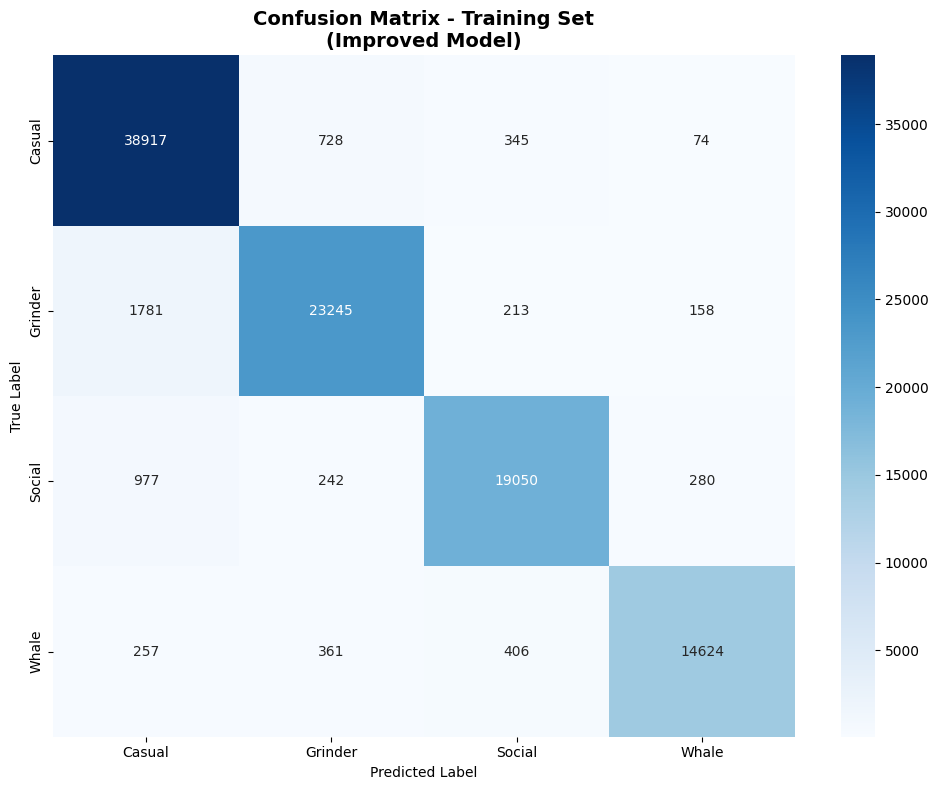


📊 Distribution Comparison:

  Training Set:
segment
0    40064
1    25397
2    20549
3    15648
Name: count, dtype: int64

  Test Predictions:
segment
0    11221
1     6032
2     5027
3     3609
Name: count, dtype: int64


In [26]:
print("\n" + "=" * 80)
print("PREDICTION ANALYSIS")
print("=" * 80)

# Training set performance
print("\n📋 Training Set Classification Report:")
y_train_pred_final = final_model.predict(X_train_selected)
print(classification_report(y_train, y_train_pred_final,
                          target_names=['Casual', 'Grinder', 'Social', 'Whale'],
                          digits=4))

# Confusion Matrix
print("\n📊 Training Set Confusion Matrix:")
cm = confusion_matrix(y_train, y_train_pred_final)
print(cm)

# Visualize Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Casual', 'Grinder', 'Social', 'Whale'],
            yticklabels=['Casual', 'Grinder', 'Social', 'Whale'])
plt.title('Confusion Matrix - Training Set\n(Improved Model)', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix_improved.png', dpi=300, bbox_inches='tight')
print("\n✅ Confusion matrix saved as 'confusion_matrix_improved.png'")
plt.show()

# Distribution comparison
print("\n📊 Distribution Comparison:")
print(f"\n  Training Set:")
print(pd.Series(y_train).value_counts().sort_index())
print(f"\n  Test Predictions:")
print(submission['segment'].value_counts().sort_index())


In [27]:
print("\n" + "=" * 80)
print("✅ IMPROVED PREDICTION COMPLETED!")
print("=" * 80)
print(f"\n🎯 Final Model: {best_model_name}")
print(f"   Training Macro F1: {f1_score(y_train, y_train_pred_final, average='macro'):.4f}")
print(f"\n📁 Output Files:")
print(f"   - task2_submission_improved.csv")
print(f"   - confusion_matrix_improved.png")
print("\n📈 Expected Improvements:")
print("   ✓ Reduced overfitting (gap <5%)")
print("   ✓ Better feature engineering (40+ new features)")
print("   ✓ ADASYN sampling (better than SMOTE)")
print("   ✓ Feature selection (top 50 features)")
print("   ✓ Stacking ensemble (better than voting)")
print("   ✓ Probability calibration")
print("\n🚀 Next Steps:")
print("   1. Submit to leaderboard")
print("   2. Compare with previous submission")
print("   3. If score improved, iterate further")
print("   4. If not, try different ensemble strategies")
print("=" * 80)


✅ IMPROVED PREDICTION COMPLETED!

🎯 Final Model: Stacking Ensemble
   Training Macro F1: 0.9422

📁 Output Files:
   - task2_submission_improved.csv
   - confusion_matrix_improved.png

📈 Expected Improvements:
   ✓ Reduced overfitting (gap <5%)
   ✓ Better feature engineering (40+ new features)
   ✓ ADASYN sampling (better than SMOTE)
   ✓ Feature selection (top 50 features)
   ✓ Stacking ensemble (better than voting)
   ✓ Probability calibration

🚀 Next Steps:
   1. Submit to leaderboard
   2. Compare with previous submission
   3. If score improved, iterate further
   4. If not, try different ensemble strategies


In [28]:
print("\n[11] Saving Final Ensemble Model...")

with open('final_ensemble_improved.pkl', 'wb') as f:
    pickle.dump(final_model, f)

print("✅ Final model saved as 'final_ensemble_improved.pkl'")
print("\nYou can load this model later with:")
print("  with open('final_ensemble_improved.pkl', 'rb') as f:")
print("      model = pickle.load(f)")


[11] Saving Final Ensemble Model...
✅ Final model saved as 'final_ensemble_improved.pkl'

You can load this model later with:
  with open('final_ensemble_improved.pkl', 'rb') as f:
      model = pickle.load(f)
